In [18]:
import os
import glob
from pathlib import Path
import pandas as pd
import json
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

def get_best_downstream_loss(tb_dir):
    ea = event_accumulator.EventAccumulator(tb_dir)
    ea.Reload()
    try:  
        loss = ea.Scalars('best_downstream_loss__gen_9')[-1].value
        return loss
    except:
        return None
    

exps =[f"exp6_{i}" for i in range(4)]+ [f"exp8_{i}" for i in range(4, 8)] + \
        [f"exp10_{i}" for i in range(4)] + [f"exp11_{i}" for i in range(4)]

# get all experiment paths from the cc directory and bd directory (nothing in bd)
cc_p = Path('/home/noah/ESSL/cc_experiments/')
bd_p = Path('/home/noah/ESSL/exps/iteration4/')
cc_dirs = [str(p_i) for p_i in list(cc_p.glob('**'))]
bd_dirs = [str(p_i) for p_i in list(bd_p.glob('**'))]
dirs = cc_dirs + bd_dirs
# collect all experiments
csv_map = []
for e in exps: 
    e_dirs = [p_i for p_i in dirs if e == p_i.split("/")[-1]]
    csv_map_i = []
    for e_dir in e_dirs:
        # check that experiments actually completed
        model_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/models"))])
        plot_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/plots"))])
        tbs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/tensorboard"))])
        finished_exps = model_dirs.intersection(plot_dirs)
        finished_exps_tbs = finished_exps.intersection(tbs)
        if len(finished_exps) != len(finished_exps_tbs):
            continue
        # add comleted exps to csv_map_i
        for f_e in finished_exps:
            csv_map_i.append([e, os.path.basename(f_e), e_dir, f_e])
    # append all results form exps to csv_map
    csv_map+=sorted(csv_map_i, key=lambda x: str(x[1]))
# create df for csv_map
columns = ["exp", "seed", "exp_dir", "seed_dir"]
df = pd.DataFrame(csv_map, columns=columns)
df = df.drop_duplicates(["exp", "seed"],keep= 'last')
df.to_csv("/home/noah/ESSL/PAPER/results/all_exps_map.csv")
pop_vals_df = []
for exp in df["exp"].unique():
    exp_df = df[df["exp"] == exp]
    pop_vals = []
    for _, row in exp_df.iterrows():
        outcomes_dir = os.path.join(row["seed_dir"], "outcomes.json")
        algo = get_algorithm(os.path.join(row["seed_dir"], "params.txt"))
        try:
            tb = glob.glob(os.path.join(row["seed_dir"], "tensorboard/*/*.tfevents*" ))[0]
            best_loss = get_best_downstream_loss(tb)
        except:
            best_loss = None
        with open(outcomes_dir, "r") as f:
            outcomes = json.load(f)
            pop_vals+=[[exp, algo, row["seed"], i[0], i[1], best_loss] for i in outcomes["pop_vals"]]
    pop_vals_df+=pop_vals
pop_vals_df    
df = pd.DataFrame(pop_vals_df, columns = ["exp", "algo", "seed", "generation", "fitness", "best_loss"])
BS = {'exp6': 32, 'exp8':256, 'exp10':256, 'exp11':32}
df['batch size'] = df['exp'].apply(lambda x: BS[x.split('_')[0]])
DS = {'exp6': 'cifar10', 'exp8':'cifar10', 'exp10':'svhn', 'exp11':'svhn'}
df['data set']  = df['exp'].apply(lambda x: DS[x.split('_')[0]])
df.to_csv("/home/noah/ESSL/PAPER/results/full_results.csv")

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
0,exp6_0,NNCLR,0,0,83.07,0.513013,32,cifar10
1,exp6_0,NNCLR,0,0,82.07,0.513013,32,cifar10
2,exp6_0,NNCLR,0,0,82.37,0.513013,32,cifar10
3,exp6_0,NNCLR,0,0,83.21,0.513013,32,cifar10
4,exp6_0,NNCLR,0,0,83.23,0.513013,32,cifar10
...,...,...,...,...,...,...,...,...
2995,exp6_3,SimSiam,3,9,83.13,0.529961,32,cifar10
2996,exp6_3,SimSiam,3,9,84.08,0.529961,32,cifar10
2997,exp6_3,SimSiam,3,9,82.38,0.529961,32,cifar10
2998,exp6_3,SimSiam,3,9,83.61,0.529961,32,cifar10


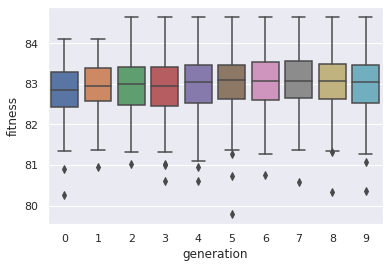

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
0,exp6_0,NNCLR,0,0,83.07,0.513013,32,cifar10
1,exp6_0,NNCLR,0,0,82.07,0.513013,32,cifar10
2,exp6_0,NNCLR,0,0,82.37,0.513013,32,cifar10
3,exp6_0,NNCLR,0,0,83.21,0.513013,32,cifar10
4,exp6_0,NNCLR,0,0,83.23,0.513013,32,cifar10
...,...,...,...,...,...,...,...,...
2995,exp6_3,SimSiam,3,9,83.13,0.529961,32,cifar10
2996,exp6_3,SimSiam,3,9,84.08,0.529961,32,cifar10
2997,exp6_3,SimSiam,3,9,82.38,0.529961,32,cifar10
2998,exp6_3,SimSiam,3,9,83.61,0.529961,32,cifar10


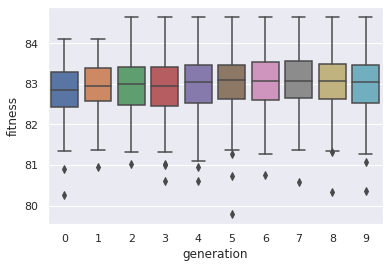

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
0,exp6_0,NNCLR,0,0,83.07,0.513013,32,cifar10
1,exp6_0,NNCLR,0,0,82.07,0.513013,32,cifar10
2,exp6_0,NNCLR,0,0,82.37,0.513013,32,cifar10
3,exp6_0,NNCLR,0,0,83.21,0.513013,32,cifar10
4,exp6_0,NNCLR,0,0,83.23,0.513013,32,cifar10
...,...,...,...,...,...,...,...,...
2995,exp6_3,SimSiam,3,9,83.13,0.529961,32,cifar10
2996,exp6_3,SimSiam,3,9,84.08,0.529961,32,cifar10
2997,exp6_3,SimSiam,3,9,82.38,0.529961,32,cifar10
2998,exp6_3,SimSiam,3,9,83.61,0.529961,32,cifar10


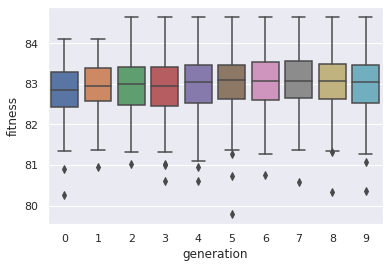

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
0,exp6_0,NNCLR,0,0,83.07,0.513013,32,cifar10
1,exp6_0,NNCLR,0,0,82.07,0.513013,32,cifar10
2,exp6_0,NNCLR,0,0,82.37,0.513013,32,cifar10
3,exp6_0,NNCLR,0,0,83.21,0.513013,32,cifar10
4,exp6_0,NNCLR,0,0,83.23,0.513013,32,cifar10
...,...,...,...,...,...,...,...,...
2995,exp6_3,SimSiam,3,9,83.13,0.529961,32,cifar10
2996,exp6_3,SimSiam,3,9,84.08,0.529961,32,cifar10
2997,exp6_3,SimSiam,3,9,82.38,0.529961,32,cifar10
2998,exp6_3,SimSiam,3,9,83.61,0.529961,32,cifar10


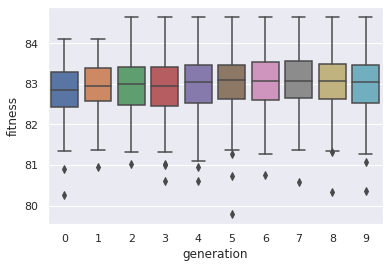

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
3000,exp8_4,SwaV,0,0,82.72,0.513028,256,cifar10
3001,exp8_4,SwaV,0,0,81.30,0.513028,256,cifar10
3002,exp8_4,SwaV,0,0,83.53,0.513028,256,cifar10
3003,exp8_4,SwaV,0,0,81.53,0.513028,256,cifar10
3004,exp8_4,SwaV,0,0,83.19,0.513028,256,cifar10
...,...,...,...,...,...,...,...,...
7795,exp8_7,NNCLR,7,9,83.33,0.530943,256,cifar10
7796,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7797,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7798,exp8_7,NNCLR,7,9,84.15,0.530943,256,cifar10


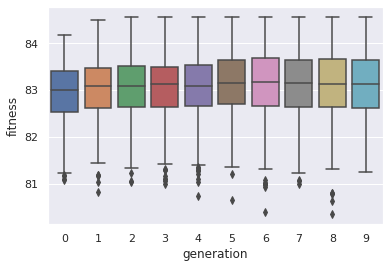

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
3000,exp8_4,SwaV,0,0,82.72,0.513028,256,cifar10
3001,exp8_4,SwaV,0,0,81.30,0.513028,256,cifar10
3002,exp8_4,SwaV,0,0,83.53,0.513028,256,cifar10
3003,exp8_4,SwaV,0,0,81.53,0.513028,256,cifar10
3004,exp8_4,SwaV,0,0,83.19,0.513028,256,cifar10
...,...,...,...,...,...,...,...,...
7795,exp8_7,NNCLR,7,9,83.33,0.530943,256,cifar10
7796,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7797,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7798,exp8_7,NNCLR,7,9,84.15,0.530943,256,cifar10


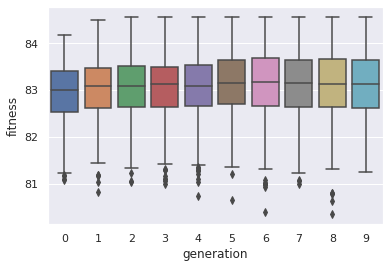

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
3000,exp8_4,SwaV,0,0,82.72,0.513028,256,cifar10
3001,exp8_4,SwaV,0,0,81.30,0.513028,256,cifar10
3002,exp8_4,SwaV,0,0,83.53,0.513028,256,cifar10
3003,exp8_4,SwaV,0,0,81.53,0.513028,256,cifar10
3004,exp8_4,SwaV,0,0,83.19,0.513028,256,cifar10
...,...,...,...,...,...,...,...,...
7795,exp8_7,NNCLR,7,9,83.33,0.530943,256,cifar10
7796,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7797,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7798,exp8_7,NNCLR,7,9,84.15,0.530943,256,cifar10


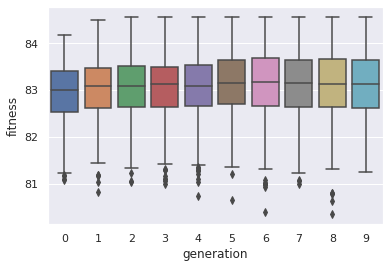

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
3000,exp8_4,SwaV,0,0,82.72,0.513028,256,cifar10
3001,exp8_4,SwaV,0,0,81.30,0.513028,256,cifar10
3002,exp8_4,SwaV,0,0,83.53,0.513028,256,cifar10
3003,exp8_4,SwaV,0,0,81.53,0.513028,256,cifar10
3004,exp8_4,SwaV,0,0,83.19,0.513028,256,cifar10
...,...,...,...,...,...,...,...,...
7795,exp8_7,NNCLR,7,9,83.33,0.530943,256,cifar10
7796,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7797,exp8_7,NNCLR,7,9,83.87,0.530943,256,cifar10
7798,exp8_7,NNCLR,7,9,84.15,0.530943,256,cifar10


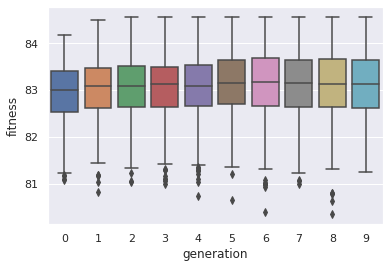

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
13050,exp11_0,SwaV,0,0,89.605101,0.301111,32,svhn
13051,exp11_0,SwaV,0,0,90.381069,0.301111,32,svhn
13052,exp11_0,SwaV,0,0,90.269668,0.301111,32,svhn
13053,exp11_0,SwaV,0,0,88.590965,0.301111,32,svhn
13054,exp11_0,SwaV,0,0,89.762600,0.301111,32,svhn
...,...,...,...,...,...,...,...,...
14995,exp11_3,NNCLR,2,9,92.528427,0.302991,32,svhn
14996,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14997,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14998,exp11_3,NNCLR,2,9,93.350492,0.302991,32,svhn


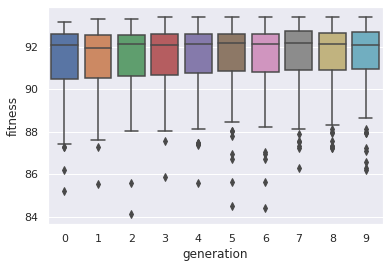

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
13050,exp11_0,SwaV,0,0,89.605101,0.301111,32,svhn
13051,exp11_0,SwaV,0,0,90.381069,0.301111,32,svhn
13052,exp11_0,SwaV,0,0,90.269668,0.301111,32,svhn
13053,exp11_0,SwaV,0,0,88.590965,0.301111,32,svhn
13054,exp11_0,SwaV,0,0,89.762600,0.301111,32,svhn
...,...,...,...,...,...,...,...,...
14995,exp11_3,NNCLR,2,9,92.528427,0.302991,32,svhn
14996,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14997,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14998,exp11_3,NNCLR,2,9,93.350492,0.302991,32,svhn


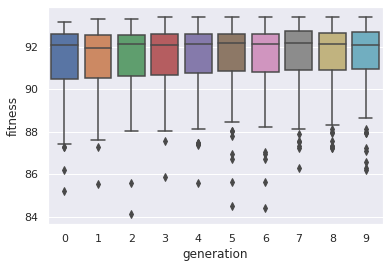

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
13050,exp11_0,SwaV,0,0,89.605101,0.301111,32,svhn
13051,exp11_0,SwaV,0,0,90.381069,0.301111,32,svhn
13052,exp11_0,SwaV,0,0,90.269668,0.301111,32,svhn
13053,exp11_0,SwaV,0,0,88.590965,0.301111,32,svhn
13054,exp11_0,SwaV,0,0,89.762600,0.301111,32,svhn
...,...,...,...,...,...,...,...,...
14995,exp11_3,NNCLR,2,9,92.528427,0.302991,32,svhn
14996,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14997,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14998,exp11_3,NNCLR,2,9,93.350492,0.302991,32,svhn


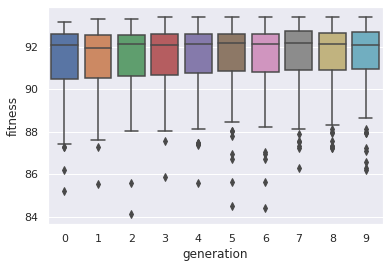

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
13050,exp11_0,SwaV,0,0,89.605101,0.301111,32,svhn
13051,exp11_0,SwaV,0,0,90.381069,0.301111,32,svhn
13052,exp11_0,SwaV,0,0,90.269668,0.301111,32,svhn
13053,exp11_0,SwaV,0,0,88.590965,0.301111,32,svhn
13054,exp11_0,SwaV,0,0,89.762600,0.301111,32,svhn
...,...,...,...,...,...,...,...,...
14995,exp11_3,NNCLR,2,9,92.528427,0.302991,32,svhn
14996,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14997,exp11_3,NNCLR,2,9,92.685925,0.302991,32,svhn
14998,exp11_3,NNCLR,2,9,93.350492,0.302991,32,svhn


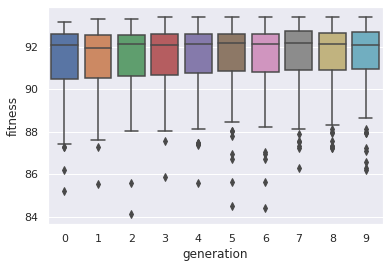

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
7800,exp10_0,SwaV,0,0,88.982790,0.304896,256,svhn
7801,exp10_0,SwaV,0,0,89.543639,0.304896,256,svhn
7802,exp10_0,SwaV,0,0,90.626921,0.304896,256,svhn
7803,exp10_0,SwaV,0,0,89.059619,0.304896,256,svhn
7804,exp10_0,SwaV,0,0,88.963583,0.304896,256,svhn
...,...,...,...,...,...,...,...,...
13045,exp10_3,NNCLR,8,9,92.201905,0.305705,256,svhn
13046,exp10_3,NNCLR,8,9,91.479717,0.305705,256,svhn
13047,exp10_3,NNCLR,8,9,91.452827,0.305705,256,svhn
13048,exp10_3,NNCLR,8,9,92.693608,0.305705,256,svhn


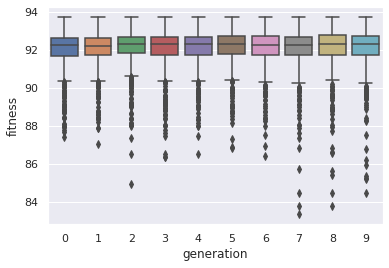

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
7800,exp10_0,SwaV,0,0,88.982790,0.304896,256,svhn
7801,exp10_0,SwaV,0,0,89.543639,0.304896,256,svhn
7802,exp10_0,SwaV,0,0,90.626921,0.304896,256,svhn
7803,exp10_0,SwaV,0,0,89.059619,0.304896,256,svhn
7804,exp10_0,SwaV,0,0,88.963583,0.304896,256,svhn
...,...,...,...,...,...,...,...,...
13045,exp10_3,NNCLR,8,9,92.201905,0.305705,256,svhn
13046,exp10_3,NNCLR,8,9,91.479717,0.305705,256,svhn
13047,exp10_3,NNCLR,8,9,91.452827,0.305705,256,svhn
13048,exp10_3,NNCLR,8,9,92.693608,0.305705,256,svhn


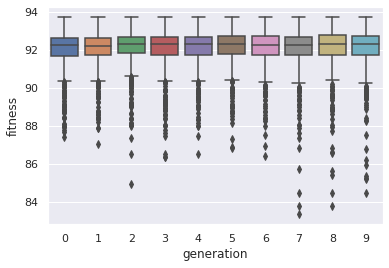

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
7800,exp10_0,SwaV,0,0,88.982790,0.304896,256,svhn
7801,exp10_0,SwaV,0,0,89.543639,0.304896,256,svhn
7802,exp10_0,SwaV,0,0,90.626921,0.304896,256,svhn
7803,exp10_0,SwaV,0,0,89.059619,0.304896,256,svhn
7804,exp10_0,SwaV,0,0,88.963583,0.304896,256,svhn
...,...,...,...,...,...,...,...,...
13045,exp10_3,NNCLR,8,9,92.201905,0.305705,256,svhn
13046,exp10_3,NNCLR,8,9,91.479717,0.305705,256,svhn
13047,exp10_3,NNCLR,8,9,91.452827,0.305705,256,svhn
13048,exp10_3,NNCLR,8,9,92.693608,0.305705,256,svhn


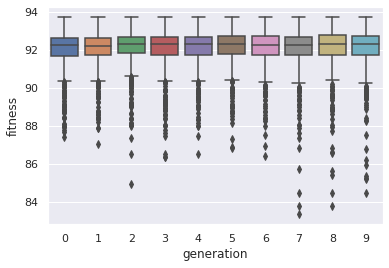

,exp,algo,seed,generation,fitness,best_loss,batch size,data set
7800,exp10_0,SwaV,0,0,88.982790,0.304896,256,svhn
7801,exp10_0,SwaV,0,0,89.543639,0.304896,256,svhn
7802,exp10_0,SwaV,0,0,90.626921,0.304896,256,svhn
7803,exp10_0,SwaV,0,0,89.059619,0.304896,256,svhn
7804,exp10_0,SwaV,0,0,88.963583,0.304896,256,svhn
...,...,...,...,...,...,...,...,...
13045,exp10_3,NNCLR,8,9,92.201905,0.305705,256,svhn
13046,exp10_3,NNCLR,8,9,91.479717,0.305705,256,svhn
13047,exp10_3,NNCLR,8,9,91.452827,0.305705,256,svhn
13048,exp10_3,NNCLR,8,9,92.693608,0.305705,256,svhn


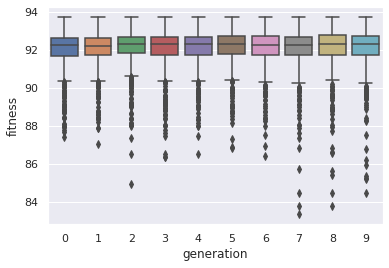

<Figure size 432x288 with 0 Axes>

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
# groupby dataset
for _, df_ds in df.groupby("data set"):
    for _, df_ds_bs in df_ds.groupby("batch size"):
        for _, df_ds_bs_al in df_ds_bs.groupby("algo"):
            display(df_ds_bs)
            sns.boxplot(df_ds_bs, x = "generation", y="fitness")
            plt.show()
            plt.clf()